# Stochastic Simulation

*Winter Semester 2024/25*

13.12.2024

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 06
</h3>

---

<h1 align="center">
Variance Reduction Techniques
</h1>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from ipywidgets import interact
from scipy.stats import norm, multivariate_normal
from scipy.integrate import nquad
from typing import Tuple
from tqdm.notebook import tqdm

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Exercise 1

Suppose that we want to compute $p=\mathbb{P}(\boldsymbol{X}\in A)$, where
$\boldsymbol{X}$ is a $d$-dimensional Gaussian random vector with mean
$\boldsymbol{\mu} = \boldsymbol{0}$ and covariance matrix $\Sigma$. If
the (Borel) set $A\subseteq\mathbb{R}^d$ contains the mean $\boldsymbol{\mu}$,
then the event $\boldsymbol{X}\in A$ is typically not rare, and the
use of importance sampling is generally unnecessary. If, on the other
hand, $\boldsymbol{\mu}\not\in A$ and $p$ is small, then one may wish
to consider the use of importance sampling. Let $\mathbb{P}^\ast$ denote the
optimal (yet impractical) sampling measure with density $g^\ast$, that
is
\begin{equation*}
  d\mathbb{P}^\ast = g^\ast\,d\boldsymbol{x} = \frac{1}{\mathbb{P}(\boldsymbol{X}\in A)} \mathbb{I}_A \phi_{\Sigma}\,d\boldsymbol{x}\;,
\end{equation*}
where $\phi_{\Sigma}$ is the density of the
$\mathcal{N}(\boldsymbol{0},\Sigma)$ distribution. Given the rapid
decay of $\phi_{\Sigma}(\boldsymbol{x})$ as
${\Vert\boldsymbol{x} \Vert}_2\to \infty$, most of the mass of
$\mathbb{P}^\ast$ is typically located at the maximizer $\boldsymbol{x}^\ast$
of $\phi_{\Sigma}$ over $A$ (which we assume to exist uniquely). This
suggests using an importance sampling distribution $\tilde{\mathbb{P}}$ with
density $g$ that concentrates most of its mass near
$\boldsymbol{x}^\ast$, that makes $g$ easily computable, and from
which realizations can efficiently be generated. 

1. One such importance sampling distribution is the Gaussian
  distribution centered in $\boldsymbol{x}^\ast$ with covariance
  matrix $\Sigma$. Describe the importance sampling algorithm to
  estimate $p$.

Using $\boldsymbol{x}^\ast \in \arg \max_{\boldsymbol{x} \in A}\phi_{\Sigma}(\boldsymbol{x})$ (possibly making the maximizer
  unique) one can use the importance algorithm as described in the
  lecture notes. As a consequence of using a Gaussian importance
  distribution $g$ with mean $\boldsymbol{x}^\ast$ and the same
  covariance as $\phi_{\Sigma}$, the weight $w := \phi_{\Sigma}/g$ can
  be written as
  \begin{equation*}
    w(\boldsymbol{x}) = \exp{\biggl(-{\boldsymbol{x}^\ast}^T\Sigma^{-1}\boldsymbol{x} + \frac{1}{2}{\boldsymbol{x}^\ast}^T\Sigma^{-1}\boldsymbol{x}^\ast \biggr)}\;,
  \end{equation*}
  which is easily implemented.

2. Implement your algorithm for $d=2$. Take  $A=\bigl\{\boldsymbol{x}=(x_1,x_2)\in\mathbb{R}^2\colon x_i\ge
  a,\,i=1,2\bigr\}$ and
  \begin{equation*}
    \Sigma = \begin{pmatrix} 4 & -1\\ -1 & 4 \end{pmatrix}\;.
  \end{equation*}
  Then carry out the following points for $a=1,3,10$:
   1. First, try to provide simulation estimates of $p= \mathbb{P}(\boldsymbol{X}\in A)$ and the associated $95\%$ confidence interval using the (naive) crude Monte Carlo method.
    2. Next, find the point $\boldsymbol{x}^\ast$ that maximizes the $\mathcal{N}(\boldsymbol{0},\Sigma)$ density over $A$ and repeat point A., with the crude Monte Carlo method replaced by importance sampling, where the importance distribution is $\mathcal{N}(\boldsymbol{x}^\ast,\Sigma)$.
    3. In point B., experiment with importance distributions of the form $\mathcal{N}(\boldsymbol{x}^\ast,\delta \Sigma)$ for different $\delta>0$.

**Hint:** You can use [`scipy.integrate.nquad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html) for approximating the "true" value of $p$.

In [3]:
def crude_Monte_Carlo(N: int, a: float) -> float:
    """
    Estimates the probability of both components of a random variable X being greater
    than or equal to `a`, using a crude Monte Carlo simulation.
    Returns estimates for mean as well as variance.
    """
    x = phi.rvs(size=N)
    psi = lambda x, a: (x[:, 0] >= a) * (x[:, 1] >= a)
    z = psi(x, a)
    mc_mean = np.mean(z)
    mc_var = np.var(z, ddof=1)
    return mc_mean, mc_var

In [4]:
def importance_sampling(N: int, a: float, delta: float=1.0, fix_seed: bool=False) -> float:
    """
    Estimates the probability of both components of a random variable X being greater
    than or equal to `a`, using importance sampling with a Gaussian distribution.
    Returns estimates for mean as well as variance.
    """
    if fix_seed:
        np.random.seed(999)
    x_star = np.array([a, a])
    g = multivariate_normal(mean=x_star, cov=delta * sigma)
    x = g.rvs(size=N)
    psi = lambda x, a: (x[:, 0] >= a) * (x[:, 1] >= a)
    z = psi(x, a) * phi.pdf(x) / g.pdf(x)
    mc_mean = np.mean(z)
    mc_var = np.var(z, ddof=1)
    return mc_mean, mc_var

In [5]:
sigma = np.array([
    [4, -1],
    [-1, 4],
])
phi = multivariate_normal(cov=sigma)

In [6]:
a_vals = [1, 3, 10]
true_p = [
    nquad(
        lambda x, y: phi.pdf([x, y]),
        ranges=[(a, np.inf), (a, np.inf)])[0]
    for a in a_vals
]

In [7]:
alpha = 0.05
cval = norm().ppf(1 - alpha / 2)

N = 100_000

print(f"Crude Monte Carlo with N = {N} samples\n" + "-" * 41)
for a in a_vals:
    p = true_p[a_vals.index(a)]
    mean, var = crude_Monte_Carlo(N, a)
    ci = cval * np.sqrt(var / N)
    
    # MSE(X) = Var(X) for an unbiased estimator X
    rel_rmse = np.sqrt(var) / np.sqrt(N) / p
    print(f"a = {a:<2} | p = {mean:.5f} ± {ci:.3e} | rel. RMSE = {rel_rmse:.3e}")

print(f"\nImportance sampling with N = {N} samples\n" + "-" * 43)
for a in a_vals:
    p = true_p[a_vals.index(a)]
    mean, var = importance_sampling(N, a)
    ci = cval * np.sqrt(var / N)
    rel_rmse = np.sqrt(var) / np.sqrt(N) / p
    print(f"a = {a:<2} | p = {mean:.5f} ± {ci:.3e} | rel. RMSE = {rel_rmse:.3e}")

Crude Monte Carlo with N = 100000 samples
-----------------------------------------
a = 1  | p = 0.06459 ± 1.523e-03 | rel. RMSE = 1.195e-02
a = 3  | p = 0.00147 ± 2.375e-04 | rel. RMSE = 8.778e-02
a = 10 | p = 0.00000 ± 0.000e+00 | rel. RMSE = 0.000e+00

Importance sampling with N = 100000 samples
-------------------------------------------
a = 1  | p = 0.06514 ± 8.752e-04 | rel. RMSE = 6.867e-03
a = 3  | p = 0.00137 ± 2.787e-05 | rel. RMSE = 1.030e-02
a = 10 | p = 0.00000 ± 6.514e-19 | rel. RMSE = 2.833e-02


In part A., we find that the crude MC method fails to provide
estimates of $p$ for $a = 10$ already when using $N = 10^5$. Part B. with $\boldsymbol{x}^\ast=(a,a)^T$ significantly improves the
situation, as the above simulation output shows, where also the
relative root mean squared error is shown.
In part C. we observe that there exists an optimal $\delta$ for each value of $a$.

In [8]:
def vary_delta_in_importance_sampling(N: int, a: float, deltas: np.array):
    """
    Perform importance sampling with varying delta values influencing the covariance.
    """
    p = true_p[a_vals.index(a)]

    means = np.zeros(len(deltas))
    vars = np.zeros(len(deltas))
    for i, delta in enumerate(deltas):
        mc_mean, mc_var = importance_sampling(N, a, delta=delta, fix_seed=True)
        means[i] = mc_mean
        vars[i] = mc_var

    rel_errs = np.abs(means - p) / p
    rel_stds = np.sqrt(vars) / p

    fig, axs = plt.subplots(ncols=2, figsize=(8, 2))
    plt.subplots_adjust(wspace=1.0)
    
    axs[0].semilogy(deltas, rel_errs)
    axs[0].set_ylabel("$|\hat{p}(\delta) - p_a| \,/\, p_a$")

    axs[1].semilogy(deltas, rel_stds)
    axs[1].set_ylabel("$\hat{\sigma}(\delta) \,/\, p_a$")

    for ax in axs:
        ax.set_xlabel("$\delta$")
        ax.set_title(f"a = {a}")

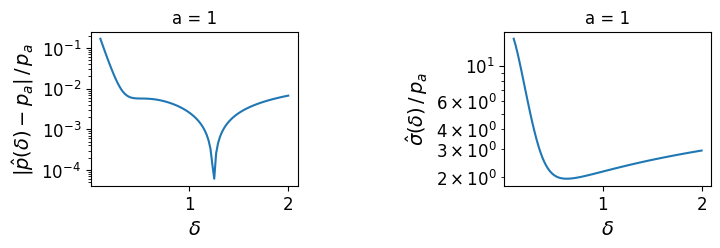

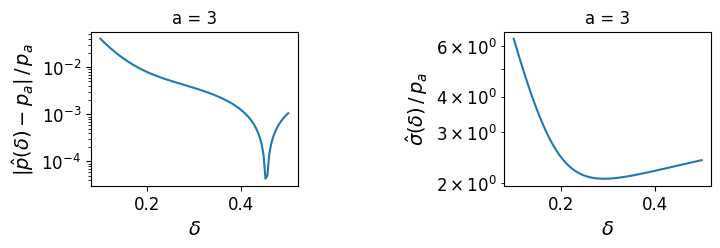

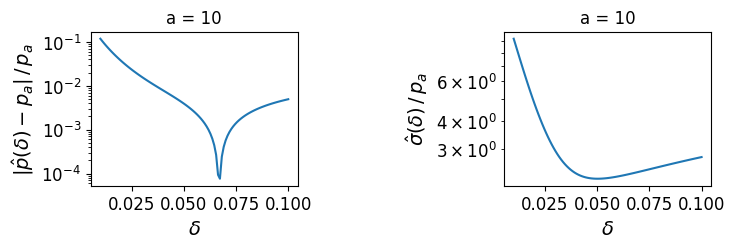

In [9]:
a = 1
deltas = np.linspace(0.1, 2, 100)
vary_delta_in_importance_sampling(N, a, deltas)

a = 3
deltas = np.linspace(0.1, 0.5, 100)
vary_delta_in_importance_sampling(N, a, deltas)

a = 10
deltas = np.linspace(0.01, 0.1, 100)
vary_delta_in_importance_sampling(N, a, deltas)

In [10]:
def plot_situation(a: float, delta: float):
    """Interaction helper."""
    fig, ax = plt.subplots()
    x = phi.rvs(size=5_000)
    ax.scatter(*x.T, s=1, c=phi.pdf(x), cmap="Blues", label="$\phi_\Sigma$");

    x_star = np.array([a, a])
    g = multivariate_normal(mean=x_star, cov=delta * sigma)
    x = g.rvs(size=5_000)
    ax.scatter(*x.T, s=1, c=g.pdf(x), cmap="Reds", label="$g_\delta$");
    
    l, r = plt.xlim()
    d, u = plt.ylim()

    A = patches.Rectangle((a, a), r-a, u-a, edgecolor="k", facecolor="k", alpha=.5, label="A")
    ax.add_patch(A)

    plt.legend(markerscale=15)
    plt.xlabel("$x_1$");
    plt.ylabel("$x_2$");

    plt.box(False)
    
    plt.title(f"Situation for $a = {a}$ and $\delta = {delta:.1f}$");

In [11]:
interact(plot_situation, a=a_vals, delta=(0.1, 1.0));

interactive(children=(Dropdown(description='a', options=(1, 3, 10), value=1), FloatSlider(value=0.55, descript…

## Exercise 2

Consider the problem of pricing a Barrier option with maturity $T>0$
based on the stock price $S$, which is given as the solution to the
stochastic differential equation
\begin{equation*}
  dS = rS\,dt + \sigma S\,dW\;,\quad S(0) = S_0\;,
\end{equation*}
where $W$ denotes a standard one-dimensional Wiener process. One can
show that $S_t = S_0e^{X_t}$, where
$X_t = (r-\sigma^2/2)t + \sigma W_t$ with $W$ being a standard Wiener
process. It follows that $S_t$ has a log-normal distribution for any
$t>0$. For $m\in\mathbb{N}$, let $t_i = i\Delta t$ with
$\Delta t = T/m$ denote the discrete observation times of the stock
price $S$ (e.g. daily at market closure). The payoff of a call
option subject to a lower barrier is then given by
\begin{equation*}
  \Psi(S_{t_0},S_{t_1},\dots, S_{T}) = {(S_T-K)}_{+}\mathbb{I}_{\bigl\{B\le \min_{i=0,\ldots,m}(S_{t_i})\bigr\}}\;,
\end{equation*}
where $B<S_0$ denotes the Barrier and $K\le S_0$ the strike
price. Here, $z_{+} = (\lvert z\rvert + z)/2$ denotes the positive
part of $z$. Estimate the expected payoff
$\mathbb{E}\bigl(\Psi(S_{t_0},S_{t_1},\dots, S_{T})\bigr)$ with antithetic
variables, using the process parameters $m=1000$, $r = 0.5$,
$\sigma = 0.3$, $T=2$, $S_0=5$, and $K=10$. Specifically, investigate
the variance reduction effect for different barrier values $B$.

Instead of using $\Psi$ as given in the exercise, we write is as a
function of $m$ increments of the $m$ independent normally distributed
random variables:
\begin{equation*}
  \Psi(S_{t_0},\dots, S_{t_m}) = \tilde\Psi(X_1,X_2,\dots,X_m)\;. %W_{t_1}-W_{t_0}, W_{t_2}-W_{t_1},\dots, W_{t_m}-W_{t_{m-1}})
\end{equation*}
This is of course possible, since $S_0$ is deterministic and because
the trajectory of the process $S$ observed at discrete times
$t_1,\dots,t_m$ is a function of independent increments
$W_{t_i}-W_{t_{i-1}}$ of the Wiener process, each following a
$\mathcal{N}(0,t_i-t_{i-1})$ distribution. Then we can apply the basic
algorithm for antithetic variables as described in the lecture notes,
viz.\
\begin{equation*}
  \hat\mu_{\text{AV}} = \frac{1}{N/2}\sum_{i=1}^{N/2}\frac{ \Psi(\boldsymbol{X}^{(i)}) + \Psi(-\boldsymbol{X}^{(i)})}{2}\;,
\end{equation*}
where each $\boldsymbol{X}^{(i)}\sim \mathcal{N}(\boldsymbol{0},I)$.

In [12]:
def price_barrier_option(
    N: int,
    B: float,
    m: int,
    r: float,
    sigma: float,
    T: float,
    S0: float,
    K: float,
    antithetic: bool=False,
    fix_seed: bool=False,
) -> float:
    """
    Price a barrier option using crude (or antithetic) Monte Carlo
    estimation with `N` or (`N/2`) samples.
    Returns the mean as well as the variance of the estimator.
    """
    if fix_seed:
        np.random.seed(999)

    payoff = lambda S: np.maximum(S[:, -1] - K, 0) * (B <= np.min(S, axis=1))

    t = np.linspace(0, T, m + 1)
    dt = T / m
    if antithetic:
        x = np.random.randn(int(N/2), m)
        x = np.vstack((x, -x))
    else:
        x = np.random.randn(N, m)
        
    W = np.zeros((N, m + 1))
    W[:, 1:] = np.sqrt(dt) * x.cumsum(axis=1)
    X = (r - sigma ** 2 / 2) * t + sigma * W
    S = S0 * np.exp(X)
    vals = payoff(S)

    if antithetic:
        vals = (vals[:int(N/2)] + vals[int(N/2):]) / 2
        
    return np.mean(vals), np.var(vals, ddof=1)

In [13]:
option_params = {
    "m": 1000,
    "r": 0.5,
    "sigma": 0.3,
    "T": 2,
    "S0": 5,
    "K": 10,
}

In [14]:
N = 10000
B = 4

In [15]:
mean_cmc, var_cmc = price_barrier_option(N, B, **option_params, antithetic=False)
mean_av, var_av = price_barrier_option(N, B, **option_params, antithetic=True)

print(f"N = {N} Samples, Barrier B = {B}\n" + "-" * 40)
print(f"Crude Monte Carlo {'':<3}| Mean: {mean_cmc:.3f}, Variance: {var_cmc:.3f}")
print(f"Antithetic variables | Mean: {mean_av:.3f}, Variance: {var_av:.3f}")

N = 10000 Samples, Barrier B = 4
----------------------------------------
Crude Monte Carlo    | Mean: 4.144, Variance: 28.855
Antithetic variables | Mean: 4.140, Variance: 6.083


In [16]:
Bs = np.linspace(0, option_params["S0"], 10)
var_reductions = np.zeros(len(Bs))

for i, B in tqdm(enumerate(Bs)):
    _, var = price_barrier_option(N, B, **option_params, antithetic=False, fix_seed=True)
    _, var_av = price_barrier_option(N, B, **option_params, antithetic=True, fix_seed=True)

    var_reductions[i] = var / var_av / 2

0it [00:00, ?it/s]

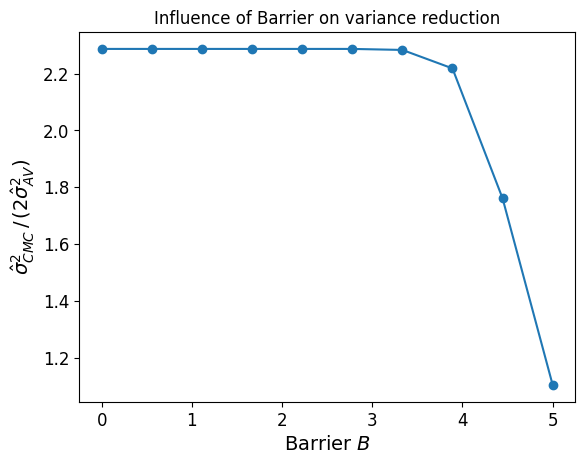

In [17]:
plt.plot(Bs, var_reductions, "o-")
plt.xlabel("Barrier $B$")
plt.ylabel("$\hat{\sigma}^2_{CMC} \,/\, (2 \hat{\sigma}^2_{AV})$")
plt.title("Influence of Barrier on variance reduction");

## Exercise 3

Consider the discrete time random walk
$\{X_n\in\mathbb{Z}\colon X_0=0, n\in\mathbb{N}\}$ with transition
probabilities:
\begin{align*}
p_{i,i+1} &\equiv\mathbb{P}(X_{n+1}=i+1\vert X_{n}=i) = a,\\
p_{i,i-1} &\equiv\mathbb{P}(X_{n+1}=i-1\vert X_{n}=i) =1-a,\quad n\ge 0,\,i\in\mathbb{Z},\ a\in(0,1),
\end{align*}
and define the stopping time $\tau_K := \inf\{n\colon X_n = K\}$ for a
given constant $K\in \mathbb{N}$. We aim at estimating $\mathbb{P}(\tau_K<T)$, for some given $T\in \mathbb{N}$.

1. Set $K=4$, $a=1/3$, $T=10$. Compute a Monte Carlo estimate of  $\mathbb{P}(\tau_K<T)$.

In [18]:
def estimate_prob(N: int, a: float, K: int, T: int, antithetic: bool=False) -> Tuple[float, float]:
    """
    Estimates the probability of a random walk reaching `K` within a given
    time horizon `T` based on `N` Monte Carlo samples.
    Returns the mean as well as the variance of the estimator.
    """
    if antithetic:
        u = np.random.rand(int(N / 2), T - 1)
        u = np.vstack((u, 1 - u))
    else:
        u = np.random.rand(N, T - 1)

    x = (2 * (u < a) - 1).cumsum(axis=1)
    z = np.any(x == K, axis=1).astype(int)
    
    if antithetic:
        z = (z[:int(N / 2)] + z[int(N / 2):]) / 2

    return np.mean(z), np.var(z, ddof=1)

In [19]:
a = 1 / 3
K = 4
T = 10

N = 100_000

In [20]:
mean_cmc, var_cmc = estimate_prob(N, a, K, T)

print(f"Crude Monte Carlo | Mean: {mean_cmc:.4f}, Variance: {var_cmc:.4f}")

Crude Monte Carlo | Mean: 0.0330, Variance: 0.0319


2. For the same values as in the previous point, estimate $\mathbb{P}(\tau_K<T)$  using the antithetic variate variance reduction technique and compare your results to those in point 1. 

Recall that one way of simulating such random walk is to sample $U\sim\mathcal{U}(0,1)$ and setting $X_{n+1}=X_n+1$ if $U<a$ and $X_{n+1}=X_n-1$ otherwise. Since $\mathbb{E}[U]=1/2$, the random variable $\tilde{U}=2\mathbb{E}[U]-U=1-U$ can be used to generate the antithetic path.

In [21]:
mean_av, var_av = estimate_prob(N, a, K, T, antithetic=True)
print(f"Antithetic variables | Mean: {mean_av:.4f}, Variance: {var_av:.4f}")

var_ratio = var_cmc / var_av / 2
print(f"\nVariance reduction compared to crude MC: {var_ratio:.4f}")

Antithetic variables | Mean: 0.0323, Variance: 0.0151

Variance reduction compared to crude MC: 1.0543


In this case, however, the variance reduction is quite poor. This is due to $Z=\mathbb{P}(\tau_K<T)$ and its antithetic variable $\tilde Z$ not having a strong negative correlation. This can be seen by examining the sample covariance matrix, which is given by  \begin{align*}
\text{Cov}(Z,\tilde Z)=\begin{pmatrix}
0.02849& -0.00091\\
-0.00091 & 0.030133
\end{pmatrix}.
\end{align*}

When analyzing the variance reduction achieved by an antithetic Monte Carlo estimator to that of a crude Monte Carlo estimator, it is essential to account for a factor of $1/2$. This adjustment is reflected in the ratio of variances as follows
$$
\frac{\mathbb{V}\textrm{ar}(\hat{p}_{AV})}{\mathbb{V}\textrm{ar}(\hat{p}_{MC})} = \frac{\tilde{\sigma}^2 / N}{\sigma^2 / (N/2)} = \frac{1}{2}\frac{\tilde{\sigma}^2}{\sigma^2},
$$
where $\sigma^2 = \mathbb{V}\textrm{ar}(Z)$ and $\tilde{\sigma}^2 = \mathbb{V}\textrm{ar}(\tilde{Z})$. We remark that in Lab 07, we use a more effective variance reduction technique (importance sampling) for the same problem. 